In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import joblib
from copy import deepcopy

In [2]:
from src.read_features import *
from src.threshold_search import *

# Load features and clf

In [3]:
clf_= joblib.load("grid_search_bert_trained_en_tda_all_ext.pkl")
clf_

Pipeline(steps=[('scaler', StandardScaler()),
                ('reduce_dim',
                 PCA(n_components=150, random_state=42, whiten=True)),
                ('clf',
                 LogisticRegression(C=0.08, class_weight='balanced',
                                    penalty='l1', random_state=42,
                                    solver='liblinear', tol=1e-06))])

In [4]:
STATE=42
model_dir = "./bert-base-cased-en-cola_32_3e-05_lr_0.01_decay_balanced/"
heads = 16 if "roberta" in model_dir.lower() else 12
layers = 24 if "roberta" in model_dir.lower() else 12
data_dir = "./data/en-cola/"

In [5]:
file_type = ".csv" # .csv or .tsv
train_set_name, valid_set_name, test_set_name = ("train", "dev","test") 
data_args = dict(((k, eval(k)) for k in ("data_dir", "file_type")))
(sents_train, y_train), (sents_valid, y_valid), (sents_test, y_test) = list(map(lambda x_: read_labels(x_, **data_args), 
                                                [x_ for x_ in (train_set_name, valid_set_name, test_set_name)]))

In [6]:
topological_thr = 6
features_dir = model_dir + "/features/"

In [7]:
kwargs = dict(((k, eval(k)) for k in ("features_dir", "model_dir", "topological_thr")))
kwargs["heads"] = heads
kwargs["layers"] =layers
X_train, X_valid, X_test = list(map(lambda x_: load_features(x_, **kwargs), [x_ for x_ in (train_set_name, valid_set_name, test_set_name)]))

Loading test features...: 100%|██████████| 432/432 [00:02<00:00, 177.40it/s]


In [8]:
# # Exclude weakly connected components equal to b0 Betti number
X_train = X_train.iloc[:, ~X_train.columns.str.startswith('w')]
X_valid = X_valid.loc[:, X_train.columns]
X_test = X_test.loc[:, X_train.columns]

var_thr = VarianceThreshold(threshold = 0.00001)
var_thr.fit(X_train)
not_constant_f = var_thr.get_support()
X_train = X_train.loc[:, not_constant_f]
X_valid = X_valid.loc[:, not_constant_f]
X_test = X_test.loc[:, not_constant_f]

In [9]:
yhat_train = clf_.predict_proba(X_train)[:, 1]
thr_mcc, _, _ = print_thresholds(y_train, yhat_train)
yhat_valid = clf_.predict_proba(X_valid)[:, 1]
y_pred_thr_mcc_valid = np.where(yhat_valid >= thr_mcc, 1, 0)
print_scores(y_valid, y_pred_thr_mcc_valid)
yhat_test = clf_.predict_proba(X_test)[:, 1]
y_pred_thr_mcc = np.where(yhat_test >= thr_mcc, 1, 0)
print_scores(y_test, y_pred_thr_mcc)

Search for the best threshold by maximizing "balanced_accuracy":
Threshold =	0.5491960548975362
Bal. Acc. =	0.9748822485850652
Accuracy =	0.974155069582505
MCC score =	0.9390519531474635	

Search for the best threshold by maximizing "matthews_corrcoef":
Threshold =	0.5186247677113287
Bal. Acc. =	0.9741618757841775
Accuracy =	0.9742720149690095
MCC score =	0.9391227533362092	

Bal. Acc. =	0.832
Accuracy =	0.867
MCC score =	0.682	

Bal. Acc. =	0.755
Accuracy =	0.808
MCC score =	0.538	



(0.8081395348837209, 0.5379012017495794)

In [10]:
yhat_train = clf_.predict_proba(X_valid)[:, 1]
thr_mcc, _, _ = print_thresholds(y_valid, yhat_train)
yhat_valid = clf_.predict_proba(X_valid)[:, 1]
y_pred_thr_mcc_valid = np.where(yhat_valid >= thr_mcc, 1, 0)
print_scores(y_valid, y_pred_thr_mcc_valid)
yhat_test = clf_.predict_proba(X_test)[:, 1]
y_pred_thr_mcc = np.where(yhat_test >= thr_mcc, 1, 0)
print_scores(y_test, y_pred_thr_mcc)

Search for the best threshold by maximizing "balanced_accuracy":
Threshold =	0.7609008242557983
Bal. Acc. =	0.8656350414341282
Accuracy =	0.8804554079696395
MCC score =	0.7229310533133542	

Search for the best threshold by maximizing "matthews_corrcoef":
Threshold =	0.7073809421330731
Bal. Acc. =	0.865288347708439
Accuracy =	0.8823529411764706
MCC score =	0.7257083316368296	

Bal. Acc. =	0.865
Accuracy =	0.882
MCC score =	0.726	

Bal. Acc. =	0.776
Accuracy =	0.81
MCC score =	0.556	



(0.810077519379845, 0.5562320097937326)

In [11]:
def select_and_group(df, selectby=None, groupby=None):
    """
    Return aggregated by y_pred / y required grammar annotation(s)
    """
    df = df.copy()
    if selectby is not None:
        for c in selectby:
            df = df[df[c] == selectby[c]].copy()
    df.insert(0, 'count', 1) # add "1" for counting
    return df.groupby(groupby).sum().reset_index()

def invert_values(df):
    """
    Make all head sum values positive if they are in agreement
    with y_pred, i.e. multiply values by -1 where y_pred == 0
    """
    for i in np.where(df['y_pred'] == 0)[0]:
        start_col = df.columns.to_list().index('head_0_0')
        for j in range(start_col, start_col + 144):
            df.at[i, df.columns[j]] *= -1
#             df.at[i, df.columns[j]] *= -1 # disagreeing heads

def collect_head_layer_matrix(df):
    sum_df = pd.DataFrame(df.sum()).T
    row = sum_df.loc[0]
    count = 1.0
    if 'count' in row.keys():
        count = row['count']
    m = np.zeros((12, 12))
    for name in row.keys():
        if name.startswith('head_'):
            _, layer, head = name.split('_')
            layer = int(layer)
            head = int(head)
            m[layer, head] = row[name] / count
    return pd.DataFrame(m)

In [12]:
clf_pca=clf_
pca = clf_pca.named_steps['reduce_dim']

In [13]:
def sorted_features(v, X):
    """
    Return data frame with names and values sorted by absolute values in descending order
    Args:
        X (pandas.DataFrame) - input Frame
        v (np.array[int]) - coeffs numpy vector
    """
    idx = list(np.argsort(np.abs(v)))
    idx.reverse()
    df = pd.DataFrame([{'name': X.columns[j], 'idx': j, 'value': v[j]} for j in idx])
    return df

# PCA statistics and scores

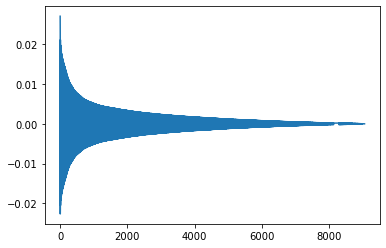

,name,idx,value
0,beginning_11_0,8981,0.027079
1,beginning_11_9,9027,0.023380
2,self_11_0,8980,0.023006
3,v_t0.05_11_0,5789,-0.022685
4,self_11_9,9026,0.021852
5,h0_t_d_11_9,8273,-0.021634
6,beginning_11_5,9006,0.021153
7,h0_t_d_10_6,8063,-0.021090
8,c_t0.05_10_7,5569,0.020957
9,b1_t0.1_11_9,6204,-0.020554


In [14]:
C = pca.components_.T / np.sqrt(pca.explained_variance_)
w = clf_pca.named_steps['clf'].coef_
f = np.dot(C, w.T)
df = sorted_features(f.ravel(), X_train)
plt.plot(df['value'])
plt.show()
df[:30]

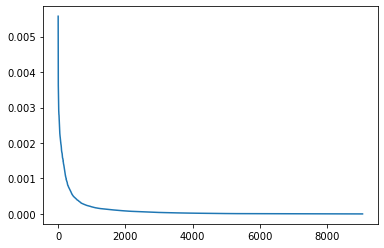

In [15]:
f2 = f * f / np.dot(f.T, f)[0,0]
df2 = sorted_features(f2.ravel(), X_train)
plt.plot(df2['value'])
plt.show()

In [16]:
XX = pd.concat([X_valid.loc[:, X_train.columns], X_test.loc[:, X_train.columns]], axis = 0).reset_index(drop=True)
yy = np.concatenate((y_valid, y_test), axis = 0)

In [17]:
scl = clf_pca.named_steps['scaler']
model = clf_pca.named_steps['clf']
X_scaled_test = scl.transform(XX)

# Compute feature contribution

In [18]:
V = np.ndarray(XX.shape)
for i in range(XX.shape[0]):
    V[i,:] = X_scaled_test[i,:] * f.ravel()
V = pd.DataFrame(data=V, columns=X_train.columns) #p_i

In [19]:
Vc = V.copy()
Vc.columns = [f"head_{x.split('_')[-2]}_{x.split('_')[-1]}" for x in Vc.columns]
Vc = Vc.T
V = pd.concat((V, Vc.groupby(Vc.index)[Vc.columns].sum().T), axis = 1)

In [20]:
yhat0 = clf_pca.predict_proba(XX)[:, 1]
thr, y_pred = find_best_threshold(yy, yhat0, scoring='matthews_corrcoef')
V.insert(len(V.columns), 'y', yy)
V.insert(len(V.columns), 'y_hat', yhat0)
V.insert(len(V.columns), 'y_pred', y_pred)
V.insert(len(V.columns), 'y_correct', 1 * (y_pred == yy))

In [21]:
cola_gr_major = pd.read_csv(data_dir + "phenomenon_minor.tsv", sep='\t', index_col=0)
cola_gr_major = cola_gr_major.reset_index()

In [22]:
V = pd.concat([V, cola_gr_major.reset_index()], axis=1)
nfeat = X_train.columns.shape[0]

In [23]:
inds=[]
for i in ['Sem  Violation', 'Infl/Agr Violation', 'Extra/Mising Expr']:
    inds.extend(list(V[V[i]==1].index))
V_synt=V.drop(inds)
V_synt[V_synt["Acceptability"]==0].index
syntactic_ph=V_synt[V_synt["Acceptability"]==0].index

In [24]:
xx=np.zeros(V.shape[0])
xx[syntactic_ph]=1
V["Syntax"]=xx

In [25]:
H = V[V.columns[nfeat:]].copy()
invert_values(H)

In [26]:
def score_mcc(y_true, y_pred):
    return matthews_corrcoef(y_true, y_pred)

excluded = {"Imperative", "Violations"}
def list_grammar_features(df):
    after = 'Acceptability'
    r = []
    take = False
    for c in df.columns:
        if take and c and c not in excluded:
            r.append(c)
        if c == after:
            take = True
    return r

def select_grammar_feature(XXX, yyy, name):
    idx = cola_gr_major[name] == 1
    Xf = XXX[idx].copy()
    yf = yyy[idx].copy()
    return idx, Xf, yf

In [27]:
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size': 14})
pd.options.display.max_colwidth = None
pd.set_option("display.precision", 5)

In [28]:
groups_s=[list_grammar_features(cola_gr_major)[1]] +list_grammar_features(cola_gr_major)[-3:] 

In [29]:
groups_s=groups_s + ['Syntax']

In [30]:
select_and_group(H, selectby=None, groupby=['y_pred', 'y', 'y_correct'])

,y_pred,y,y_correct,count,head_0_0,head_0_1,head_0_10,head_0_11,head_0_2,head_0_3,...,Ellipsis/Anaphor,S-Adjunct,Quantifier,Partitive,NPI/FCI,Comparative,Sem Violation,Infl/Agr Violation,Extra/Mising Expr,Syntax
0,0,0,1,247,0.67839,-0.20656,0.98576,-0.18378,0.71772,-0.42378,...,21,8,17,2,3,4,25,51,51,133.0
1,0,1,0,81,-0.99711,-0.56123,-0.37312,-0.27768,-0.30959,0.48367,...,23,4,5,0,1,4,0,0,0,0.0
2,1,0,0,77,0.94294,0.27926,0.20232,-0.14066,0.27295,-0.02847,...,22,1,15,3,4,2,6,10,13,48.0
3,1,1,1,638,0.69453,0.57211,-0.35741,1.19317,-0.03574,-0.30940,...,52,17,102,13,21,15,0,1,1,0.0


In [31]:
df = select_and_group(H, selectby=None, groupby=['y_pred', 'y', 'y_correct'])    
sum_df = pd.DataFrame(df.sum()).T

# Group feature contributions by grammatic annotations

In [32]:
def collect_head_layer_matrix(df):
    sum_df = pd.DataFrame(df.sum()).T
    row = sum_df.loc[0]
    count = 1.0
    if 'count' in row.keys():
        count = row['count']
    m = np.zeros((12, 12))
    for name in row.keys():
        if name.startswith('head_'):
            _, layer, head = name.split('_')
            layer = int(layer)
            head = int(head)
            m[layer, head] = row[name] / count
    return pd.DataFrame(m)

In [33]:
sns.set_style("dark")
cmap = sns.color_palette("mako", as_cmap= True)

6it [00:00, 29.54it/s]

-0.007809138916402452 0.29884884057458494
-0.011019466202340959 0.2577986281827312
-0.031392886522258745 0.2505839212216552
-0.022413862566965096 0.3577020477428465
-0.04061145001885675 0.3613115643275377
-0.02814426040588525 0.39161931325671145


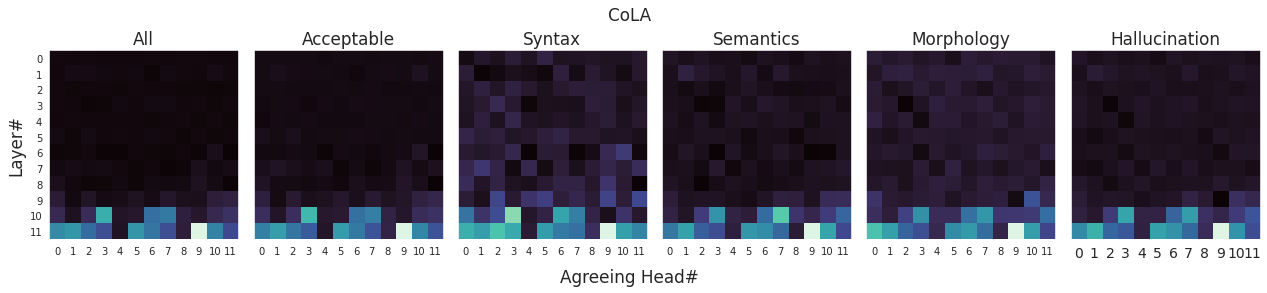

In [34]:
fig, axes = plt.subplots(nrows=1,ncols=6, figsize=(18, 4),sharey = True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
naming_={"Acceptability": "Acceptable", 'Sem  Violation':"Semantics",
 'Infl/Agr Violation': "Morphology",
 'Extra/Mising Expr': "Hallucination", "Simple": "Syntax"}
for i, gr in tqdm.tqdm(enumerate(['All', "Acceptability"] + groups_s[:-1])):
    title = gr
    if gr == 'All':
        title = r"$\bf{" + title + "}$"
        df = select_and_group(H, selectby=None, groupby=['y_pred', 'y', 'y_correct'])    
    else:
        df = select_and_group(H, selectby={gr: 1}, groupby=['y_pred', 'y', 'y_correct'])
    m = collect_head_layer_matrix(df)
    vmin = np.min(m.values, axis=(0,1))
    vmax = np.max(m.values, axis=(0,1))
    print(vmin,vmax)
    ax = axes[i]
    ax.set_title(title)
    im = ax.imshow(m,cmap=cmap, vmin=vmin, vmax=vmax)
    naming_i = naming_[gr] if gr in naming_.keys() else gr
    ax.set_title(naming_i)
    ax.tick_params(axis="x", rotation=0)
    ax.tick_params(labelsize = 10)
    ax.set_xticks([i for i in range(12)])
    ax.set_yticks([i for i in range(12)])
fig.supylabel('Layer#')
fig.supxlabel('Agreeing Head#')
plt.xticks(fontsize=14)
plt.grid(False)
fig.suptitle("CoLA")
plt.tight_layout()
# plt.savefig('cola_heads.pdf', format='pdf')
# plt.savefig('cola_heads.eps', format='eps')
# plt.savefig('cola_heads.png', format='png')
plt.show()

# Compute classifier confidence with feature contribution

In [35]:
V.insert(len(V.columns), 'sum_neg', 0.0)
V.insert(len(V.columns), 'sum_pos', 0.0)
V.insert(len(V.columns), 'sum_all', 0.0)
V.insert(len(V.columns), 'sum_abs', 0.0)
for i in range(V.shape[0]):
    col = V.loc[i].T[:len(X_train.columns)]
    col = col.to_frame(name='v')
    pos = sum(col['v'].apply(lambda x: x if x > 0 else 0))
    neg = sum(col['v'].apply(lambda x: x if x < 0 else 0))
    V.at[i, 'sum_pos'] = pos
    V.at[i, 'sum_neg'] = neg
    V.at[i, 'sum_all'] = pos + neg
    V.at[i, 'sum_abs'] = pos - neg

In [36]:
errs = V[V['y_correct'] == 0][['sum_neg', 'sum_pos', 'sum_all', 'sum_abs', 'y_hat', 'y', 'y_pred', 'Sentence']]
errs.sort_values(['sum_abs'], inplace=True, ascending=False)
errs

,sum_neg,sum_pos,sum_all,sum_abs,y_hat,y,y_pred,Sentence
674,-16.80486,17.82374,1.01888,34.62860,0.90086,0,1,Gould's performance of Bach on the piano doesn't please me anywhere as much as Ross's on the harpsichord.
589,-15.99883,17.42614,1.42731,33.42497,0.93184,0,1,"The TA's have been arguing about whether some student or other should pass, but I can't now remember which one."
603,-17.70242,14.78753,-2.91489,32.48995,0.15098,1,0,"The administration has issued a statement that it is willing to meet a student group, but I'm not sure which one."
584,-14.35347,17.50685,3.15339,31.86032,0.98715,0,1,"Sandy was trying to work out which students would be able to solve a certain problem, but she wouldn't tell us which one she was trying to work out which students would be able to solve."
655,-15.60602,14.08540,-1.52061,29.69142,0.41760,1,0,"Max seemed to be trying to begin to love Harriet, and Fred to be trying to begin to love Sue."
...,...,...,...,...,...,...,...,...
816,-5.36952,5.37531,0.00579,10.74483,0.76742,0,1,The birds gives the worm a tug.
625,-5.25652,5.44721,0.19070,10.70373,0.79878,0,1,Mary was given by John the book.
1028,-4.91771,5.74991,0.83219,10.66762,0.88290,0,1,I gave Pete the book to impress.
151,-4.94207,5.42471,0.48264,10.36678,0.84166,0,1,Brian threw the fence with the stick.


# Display head and feature most contributing to judging a sentence

In [37]:
def collect_v_i(V, f, f2, column_start=0, column_end=None, indices=None, abs_thr=None, min_thr=None, max_thr=None):
    """
    Collect V_i_j cells for selected i-indices
    and sort by their absolute values
    """
    if indices is None:
        indices = range(len(V))
    r = None
    column_end = len(f2) if column_end is None else column_end
    for i in indices:
        v = V.loc[i].T[column_start:column_end]
        v = v.to_frame(name='v')
        v.index.name = 'name'
        v.reset_index(inplace=True) # make 'name' a normal column
        v.insert(len(v.columns), 'f2', f2)
        v.insert(len(v.columns), 'f', f)
        v.insert(len(v.columns), 'y', V.loc[i]['y'])
        v.insert(len(v.columns), 'y_pred', V.loc[i]['y_pred'])
        # filter out near-zero values
        if abs_thr is not None:
            v = v[v['v'].abs() >= abs_thr]
        # filter by min/max if requested
        if min_thr is not None:
            v = v[v['v'] >= min_thr]
        if max_thr is not None:
            v = v[v['v'] <= max_thr]
        if r is None:
            r = v
        else:
            r = r.append(v, ignore_index=True)
    # sort rows by abs(v)
    r = r.reindex(r['v'].abs().sort_values(ascending=False).index)
    return r

def show_sample_top_values(V, i, mode='', n_top=8):
    print(i, ': ', cola.loc[i]['Sentence'], sep='')
    if mode == 'head':
        v = collect_v_i(V, f_heads, f2_heads, column_start=len(f2), column_end=len(f2)+144, indices=[i], abs_thr=1e-6, min_thr=None, max_thr=None)
    else:
        v = collect_v_i(V, f, f2, indices=[i], abs_thr=1e-6, min_thr=None, max_thr=None)
    print('sum(v):', sum(v['v']))
    pos = sum(v['v'].apply(lambda x: x if x > 0 else 0))
    neg = sum(v['v'].apply(lambda x: x if x < 0 else 0))
    print('sum of positives:', pos)
    print('sum of negatives:', neg)
    print('len(v):', len(v))
    label="Unacceptable" if not V['y'][i] else "Acceptable"
    label_pred="Unacceptable" if not V['y_pred'][i] else "Acceptable"
    print('y:', label, 'y_hat:', V['y_hat'][i], 'y_pred:', label_pred)
    v.plot.scatter(x='v', y='f2')
    print('\nGrammar classes:')
    display(pd.DataFrame(V.loc[i][-15:]).T)
    print('Top', n_top, 'values:')
    display(v[:n_top])
    print("Arguing heads")
    display(v[-n_top:])

In [38]:
cola=cola_gr_major

In [39]:
head_names = {}
f_heads = np.zeros((144, 1))
f2_heads = np.zeros((144, 1))
for i in range(len(XX.columns)):
    name = XX.columns[i]
    layer, head = name.split('_')[-2:]
    j = int(layer) * 12 + int(head)
    head_name = f'head_{layer}_{head}'
    f_heads[j] += f[i]
    f2_heads[j] += f2[i]

217: many information was provided.
sum(v): -6.407349548908141
sum of positives: 5.628838197650441
sum of negatives: -12.036187746558586
len(v): 9024
y: Unacceptable y_hat: 0.005381637103555483 y_pred: Unacceptable

Grammar classes:


,Subordinate/Cond,Ellipsis/Anaphor,S-Adjunct,Quantifier,Partitive,NPI/FCI,Comparative,Sem Violation,Infl/Agr Violation,Extra/Mising Expr,Syntax,sum_neg,sum_pos,sum_all,sum_abs
217,0,0,0,1,0,0,0,1,1,0,0.0,-12.03619,5.62884,-6.40735,17.66504


Top 8 values:


,name,v,f2,f,y,y_pred
9001,beginning_11_4,-0.1102,0.00255,0.01831,0,0
9040,beginning_11_11,-0.09662,0.00176,0.01522,0,0
8956,beginning_10_8,-0.08698,0.00115,0.01232,0,0
9027,beginning_11_9,-0.08464,0.00415,0.02338,0,0
5567,v_t0.75_10_7,-0.08199,0.00282,-0.01927,0,0
8991,beginning_11_2,-0.07742,0.00223,0.01714,0,0
8986,beginning_11_1,-0.07459,0.00297,0.01978,0,0
8996,beginning_11_3,-0.07366,0.00156,0.01431,0,0


Arguing heads


,name,v,f2,f,y,y_pred
3088,k_t0.1_5_10,0.0,3.55182e-11,2.16166e-06,0,0
4965,s_t0.05_9_6,0.0,3.63684e-11,-2.18738e-06,0,0
553,c_t0.5_1_0,-0.0,6.15768e-08,9.00057e-05,0,0
564,b1_t0.5_1_0,-0.0,6.15768e-08,9.00057e-05,0,0
8261,h0_n_d_m_t0.5_11_8,-0.0,1.97423e-11,1.61161e-06,0,0
7334,h0_s_6_2,-0.0,7.99552e-12,1.02562e-06,0,0
643,b0_t0.1_1_2,-0.0,1.87414e-08,4.96549e-05,0,0
6156,b0_t0.5_11_8,0.0,1.66042e-11,-1.47799e-06,0,0


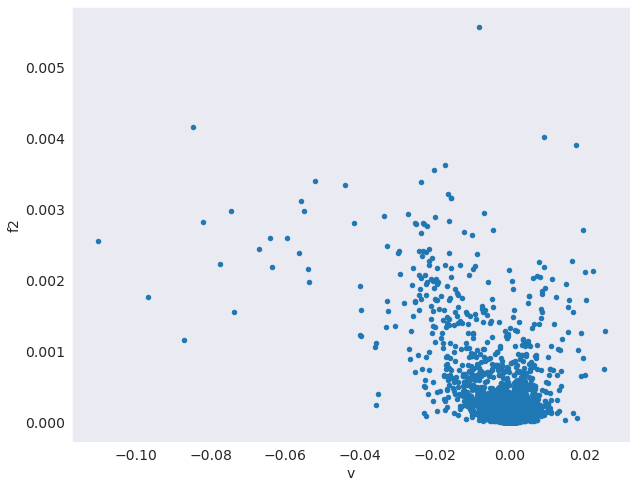

In [40]:
i = 217
show_sample_top_values(V, i, mode='')

211: The stream twists through the valley.
sum(v): 3.0923671325628828
sum of positives: 7.366993004302769
sum of negatives: -4.274625871739885
len(v): 9020
y: Acceptable y_hat: 0.9863510388288789 y_pred: Acceptable

Grammar classes:


,Subordinate/Cond,Ellipsis/Anaphor,S-Adjunct,Quantifier,Partitive,NPI/FCI,Comparative,Sem Violation,Infl/Agr Violation,Extra/Mising Expr,Syntax,sum_neg,sum_pos,sum_all,sum_abs
211,0,0,0,0,0,0,0,0,0,0,0.0,-4.27463,7.367,3.09236,11.64163


Top 8 values:


,name,v,f2,f,y,y_pred
8968,sep_10_9,0.03592,0.00152,-0.01416,1,1
8967,dot_10_9,0.03589,0.00143,-0.01370,1,1
8933,dot_10_4,0.02872,0.00135,-0.01331,1,1
5252,c_t0.05_10_0,0.02787,0.00146,-0.01384,1,1
5246,v_t0.05_10_0,0.02327,0.00212,-0.01670,1,1
8960,dot_10_8,0.02257,0.00175,-0.01517,1,1
9015,dot_11_6,0.02175,0.00221,-0.01706,1,1
7578,h1_t_b_7_7,0.02149,0.00049,0.00806,1,1


Arguing heads


,name,v,f2,f,y,y_pred
564,b1_t0.5_1_0,-0.0,6.15768e-08,9.00057e-05,1,1
553,c_t0.5_1_0,-0.0,6.15768e-08,9.00057e-05,1,1
192,v_t0.1_0_4,0.0,1.33871e-10,4.19668e-06,1,1
933,v_t0.25_1_9,0.0,1.26433e-08,-4.07842e-05,1,1
3793,e_t0.75_7_3,0.0,8.15428e-08,1.03575e-04,1,1
643,b0_t0.1_1_2,-0.0,1.87414e-08,4.96549e-05,1,1
2073,b1_t0.025_3_11,-0.0,5.09275e-10,8.18536e-06,1,1
8504,self_3_1,-0.0,1.41555e-10,-4.31543e-06,1,1


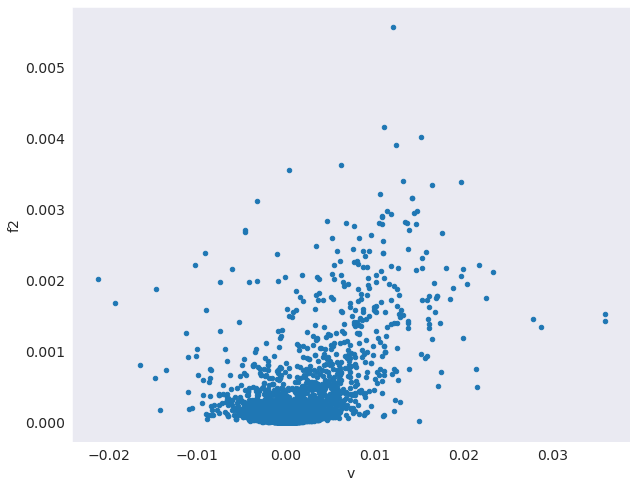

In [41]:
i = 211

show_sample_top_values(V, i, mode='')

819: Terry delighted my pain.
sum(v): -4.68997058336116
sum of positives: 5.591907222285436
sum of negatives: -10.281877805646637
len(v): 9028
y: Unacceptable y_hat: 0.02925571724348602 y_pred: Unacceptable

Grammar classes:


,Subordinate/Cond,Ellipsis/Anaphor,S-Adjunct,Quantifier,Partitive,NPI/FCI,Comparative,Sem Violation,Infl/Agr Violation,Extra/Mising Expr,Syntax,sum_neg,sum_pos,sum_all,sum_abs
819,0,0,0,0,0,0,0,1,0,0,0.0,-10.28188,5.59191,-4.68997,15.87379


Top 8 values:


,name,v,f2,f,y,y_pred
5790,v_t0.1_11_0,-0.05784,0.00222,-0.01708,0,0
2725,b1_t0.5_5_2,-0.05326,0.00009,-0.00341,0,0
5525,c_t0.25_10_6,-0.05221,0.00276,-0.01907,0,0
8981,beginning_11_0,-0.05017,0.00557,0.02708,0,0
8980,self_11_0,-0.04628,0.00402,0.02301,0,0
2716,c_t0.5_5_2,-0.04506,0.00010,-0.00358,0,0
5770,m_t0.5_10_11,-0.0436,0.00167,-0.01483,0,0
6188,v_t0.1_11_9,-0.0434,0.00312,-0.02026,0,0


Arguing heads


,name,v,f2,f,y,y_pred
4542,b0_t0.1_8_8,0.0,1.40903e-07,-1.36151e-04,0,0
553,c_t0.5_1_0,-0.0,6.15768e-08,9.00057e-05,0,0
564,b1_t0.5_1_0,-0.0,6.15768e-08,9.00057e-05,0,0
8261,h0_n_d_m_t0.5_11_8,-0.0,1.97423e-11,1.61161e-06,0,0
3793,e_t0.75_7_3,0.0,8.15428e-08,1.03575e-04,0,0
643,b0_t0.1_1_2,-0.0,1.87414e-08,4.96549e-05,0,0
6156,b0_t0.5_11_8,0.0,1.66042e-11,-1.47799e-06,0,0
7476,h0_t_d_7_0,-0.0,1.02678e-11,1.16225e-06,0,0


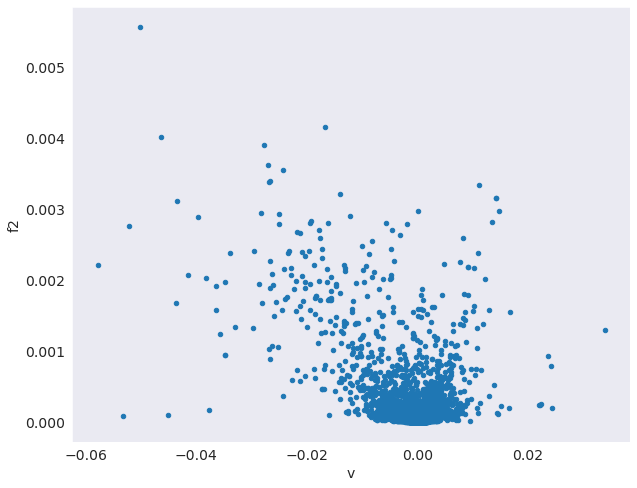

In [42]:
i = 819

show_sample_top_values(V, i, mode='')

In [43]:
cola[cola['Sentence']=="a tall building."]

,Source,Domain,Acceptability,Sentence,Simple,Copula,Pred/SC,Result/Depictive,Particle,VP Adjunct,...,Subordinate/Cond,Ellipsis/Anaphor,S-Adjunct,Quantifier,Partitive,NPI/FCI,Comparative,Sem Violation,Infl/Agr Violation,Extra/Mising Expr
403,m_02,In,1,a tall building.,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


403: a tall building.
sum(v): 1.886579591966975
sum of positives: 10.794343261432363
sum of negatives: -8.907763669465432
len(v): 9031
y: Acceptable y_hat: 0.9558312594067527 y_pred: Acceptable

Grammar classes:


,Subordinate/Cond,Ellipsis/Anaphor,S-Adjunct,Quantifier,Partitive,NPI/FCI,Comparative,Sem Violation,Infl/Agr Violation,Extra/Mising Expr,Syntax,sum_neg,sum_pos,sum_all,sum_abs
403,0,0,0,0,0,0,0,0,0,0,0.0,-8.90777,10.79435,1.88658,19.70211


Top 8 values:


,name,v,f2,f,y,y_pred
9043,sep_11_11,0.05279,0.00293,-0.01964,1,1
8934,sep_10_4,0.04953,0.00119,-0.01251,1,1
8999,sep_11_3,0.04757,0.00234,-0.01755,1,1
8021,h0_t_d_10_3,0.04691,0.00217,-0.01688,1,1
8838,sep_9_0,0.0467,0.00139,-0.01354,1,1
8994,sep_11_2,0.04611,0.00241,-0.01781,1,1
8879,beginning_9_7,0.04536,0.00112,-0.01215,1,1
8192,h0_n_d_l_t0.25_11_3,0.04343,0.00047,0.00786,1,1


Arguing heads


,name,v,f2,f,y,y_pred
3088,k_t0.1_5_10,0.0,3.55182e-11,2.16166e-06,1,1
192,v_t0.1_0_4,-0.0,1.33871e-10,4.19668e-06,1,1
564,b1_t0.5_1_0,-0.0,6.15768e-08,9.00057e-05,1,1
553,c_t0.5_1_0,-0.0,6.15768e-08,9.00057e-05,1,1
3664,v_t0.25_7_0,0.0,3.92442e-12,7.18538e-07,1,1
643,b0_t0.1_1_2,-0.0,1.87414e-08,4.96549e-05,1,1
7334,h0_s_6_2,-0.0,7.99552e-12,1.02562e-06,1,1
151,c_t0.05_0_3,-0.0,3.62820e-12,6.90887e-07,1,1


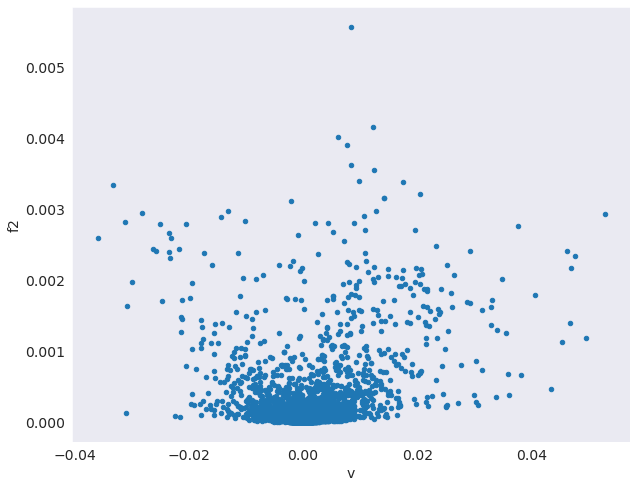

In [44]:
i = 403

show_sample_top_values(V, i, mode='')

509: He can will go
sum(v): -4.84162628379103
sum of positives: 8.143234261014355
sum of negatives: -12.984860544805384
len(v): 9027
y: Unacceptable y_hat: 0.02524294854869158 y_pred: Unacceptable

Grammar classes:


,Subordinate/Cond,Ellipsis/Anaphor,S-Adjunct,Quantifier,Partitive,NPI/FCI,Comparative,Sem Violation,Infl/Agr Violation,Extra/Mising Expr,Syntax,sum_neg,sum_pos,sum_all,sum_abs
509,0,0,0,0,0,0,0,0,0,1,0.0,-12.98486,8.14324,-4.84163,21.1281


Top 8 values:


,name,v,f2,f,y,y_pred
3672,c_t0.75_7_0,0.11365,0.00024,0.00560,0,0
3682,b1_t0.75_7_0,0.11365,0.00024,0.00560,0,0
5797,c_t0.25_11_0,-0.09067,0.00072,-0.00975,0,0
9012,beginning_11_6,-0.08677,0.00280,0.01919,0,0
9018,beginning_11_7,-0.08495,0.00290,0.01953,0,0
8974,beginning_10_11,-0.07884,0.00150,0.01404,0,0
6107,c_t0.25_11_7,-0.07039,0.00133,-0.01325,0,0
7606,h1_t_b_7_9,0.06726,0.00020,0.00519,0,0


Arguing heads


,name,v,f2,f,y,y_pred
6610,h1_n_b_l_t0.70_1_9,0.0,2.16309e-09,-1.68694e-05,0,0
6156,b0_t0.5_11_8,0.0,1.66042e-11,-1.47799e-06,0,0
4542,b0_t0.1_8_8,0.0,1.40903e-07,-1.36151e-04,0,0
3088,k_t0.1_5_10,0.0,3.55182e-11,2.16166e-06,0,0
4965,s_t0.05_9_6,0.0,3.63684e-11,-2.18738e-06,0,0
553,c_t0.5_1_0,-0.0,6.15768e-08,9.00057e-05,0,0
564,b1_t0.5_1_0,-0.0,6.15768e-08,9.00057e-05,0,0
643,b0_t0.1_1_2,-0.0,1.87414e-08,4.96549e-05,0,0


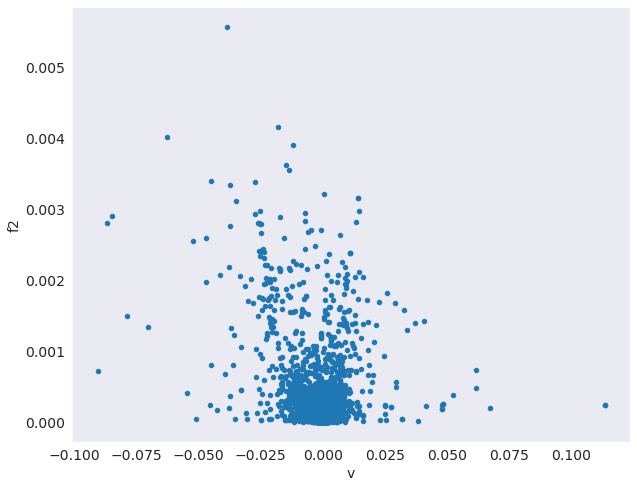

In [45]:
i = 509

show_sample_top_values(V, i, mode='')

In [46]:
# The most arguable entities (positive sum ~ negative sum)
errs.sort_values('sum_abs', inplace=True, ascending=False)
errs.head(15)

,sum_neg,sum_pos,sum_all,sum_abs,y_hat,y,y_pred,Sentence
674,-16.80486,17.82374,1.01888,34.62860,0.90086,0,1,Gould's performance of Bach on the piano doesn't please me anywhere as much as Ross's on the harpsichord.
589,-15.99883,17.42614,1.42731,33.42497,0.93184,0,1,"The TA's have been arguing about whether some student or other should pass, but I can't now remember which one."
603,-17.70242,14.78753,-2.91489,32.48995,0.15098,1,0,"The administration has issued a statement that it is willing to meet a student group, but I'm not sure which one."
584,-14.35347,17.50685,3.15339,31.86032,0.98715,0,1,"Sandy was trying to work out which students would be able to solve a certain problem, but she wouldn't tell us which one she was trying to work out which students would be able to solve."
655,-15.60602,14.08540,-1.52061,29.69142,0.41760,1,0,"Max seemed to be trying to begin to love Harriet, and Fred to be trying to begin to love Sue."
692,-16.68315,11.72606,-4.95709,28.40921,0.02255,1,0,This is the senator to whose mother's friend's sister's I sent the letter.
109,-15.44947,12.67009,-2.77938,28.11956,0.16919,1,0,"Sally is tall, and may be blond, and Sheila is short, and definitely is, blond."
595,-12.04904,15.80539,3.75634,27.85443,0.99293,0,1,In which way is Clinton anxious to find out which budget dilemmas Panetta would be willing to solve?
59,-15.67267,10.48109,-5.19158,26.15376,0.01792,1,0,"I know which book Mag read, and which book Bob said that you hadn't."
670,-14.26581,11.73128,-2.53453,25.99708,0.20644,1,0,Bill's funny story about Sue and Max's boring one about Kathy both amazed me.


In [47]:
errs.sort_values('y_hat', inplace=True, ascending=False)
errs.head(15)

,sum_neg,sum_pos,sum_all,sum_abs,y_hat,y,y_pred,Sentence
595,-12.04904,15.80539,3.75634,27.85443,0.99293,0,1,In which way is Clinton anxious to find out which budget dilemmas Panetta would be willing to solve?
660,-9.81036,13.36580,3.55545,23.17616,0.99137,0,1,Maytag will give a brand-new dryer to the winner of the Mrs.
395,-5.30428,8.62382,3.31954,13.92810,0.98909,0,1,"You may pick every flower, but leave a few for Mary."
1011,-3.95469,7.19740,3.24271,11.15209,0.98823,0,1,John believes it sincerely that Bill is here.
1040,-3.79004,6.98588,3.19584,10.77592,0.98768,0,1,John bought a dog for himself to play with.
304,-7.31345,10.50454,3.19109,17.81798,0.98762,0,1,Which house does your friend live?
584,-14.35347,17.50685,3.15339,31.86032,0.98715,0,1,"Sandy was trying to work out which students would be able to solve a certain problem, but she wouldn't tell us which one she was trying to work out which students would be able to solve."
468,-5.63646,8.63169,2.99522,14.26815,0.98498,0,1,"Only Churchill remembered Churchill giving the Blood, Sweat and Tears speech."
546,-8.12421,10.88141,2.75720,19.00562,0.98102,0,1,"Since Jill said Joe had invited Sue, we didn't have to ask who."
577,-7.39817,10.00089,2.60272,17.39906,0.97792,0,1,She said she talked to three students but I don't know how many.
